## Movie Ratings Prediction 

### Importing Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


from warnings import filterwarnings
filterwarnings('ignore')

### Reading the dataset

In [2]:
df = pd.read_csv("IMDb Movies India.csv", encoding='ISO-8859-1')

In [3]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


### Data Preprocessing

In [4]:
len(df)

15509

In [5]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(5659, 10)

In [8]:
df.isna().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [9]:
df.duplicated().sum()

0

Removing the Brackets from the Year Column

In [10]:
df["Year"].head()

1    (2019)
3    (2019)
5    (1997)
6    (2005)
8    (2012)
Name: Year, dtype: object

In [11]:
df["Year"] = df["Year"].str.replace("(", "").str.replace(")","")

In [12]:
df["Year"].head()

1    2019
3    2019
5    1997
6    2005
8    2012
Name: Year, dtype: object

### Feature Engineering

Removing the "min" from the duration column

In [13]:
df["Duration"].head()

1    109 min
3    110 min
5    147 min
6    142 min
8     82 min
Name: Duration, dtype: object

In [14]:
df["Duration"] = df["Duration"].str.replace("min","")

In [15]:
df["Duration"].head()

1    109 
3    110 
5    147 
6    142 
8     82 
Name: Duration, dtype: object

Removing commas from the votes column to convert it to numeric format

In [16]:
df["Votes"].head()

1        8
3       35
5      827
6    1,086
8      326
Name: Votes, dtype: object

In [17]:
df["Votes"] = df["Votes"].str.replace(",","").astype(float)

In [18]:
df["Votes"].head()

1       8.0
3      35.0
5     827.0
6    1086.0
8     326.0
Name: Votes, dtype: float64

Making a column for average rating of the movies a particular actor has acted in. 

In [19]:
actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']], ignore_index=True)

actor_ratings = pd.DataFrame({'Actor': actors, 'Rating': df['Rating']})

# Group the data by actor and calculate the average rating of the movies in which each actor has acted
actor_average_rating = actor_ratings.groupby('Actor')['Rating'].mean()

df['Avg_Rating_by_Actor'] = df['Actor 1'].map(actor_average_rating)

In [20]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Avg_Rating_by_Actor
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,6.200000
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,6.950000
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,6.325000
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,5.321429
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,NaN


In [21]:
df.isna().sum()

Name                     0
Year                     0
Duration                 0
Genre                    0
Rating                   0
Votes                    0
Director                 0
Actor 1                  0
Actor 2                  0
Actor 3                  0
Avg_Rating_by_Actor    861
dtype: int64

In [22]:
# Impute missing values in 'Avg_Rating_by_Actor' with the mean value of the column
mean_rating_by_actor = df['Avg_Rating_by_Actor'].mean()
df['Avg_Rating_by_Actor'] = df['Avg_Rating_by_Actor'].fillna(mean_rating_by_actor)

In [23]:
df.isna().sum()

Name                   0
Year                   0
Duration               0
Genre                  0
Rating                 0
Votes                  0
Director               0
Actor 1                0
Actor 2                0
Actor 3                0
Avg_Rating_by_Actor    0
dtype: int64

### Exploratory Data Analysis (EDA)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 5659 non-null   object 
 1   Year                 5659 non-null   object 
 2   Duration             5659 non-null   object 
 3   Genre                5659 non-null   object 
 4   Rating               5659 non-null   float64
 5   Votes                5659 non-null   float64
 6   Director             5659 non-null   object 
 7   Actor 1              5659 non-null   object 
 8   Actor 2              5659 non-null   object 
 9   Actor 3              5659 non-null   object 
 10  Avg_Rating_by_Actor  5659 non-null   float64
dtypes: float64(3), object(8)
memory usage: 659.6+ KB


In [25]:
df.describe()

,Rating,Votes,Avg_Rating_by_Actor
count,5659.000000,5659.000000,5659.000000
mean,5.898533,2697.649585,5.911668
std,1.381165,13651.503584,0.674933
min,1.100000,5.000000,1.400000
25%,5.000000,30.000000,5.685714
50%,6.100000,131.000000,5.911668
75%,6.900000,922.500000,6.200000
max,10.000000,591417.000000,9.400000


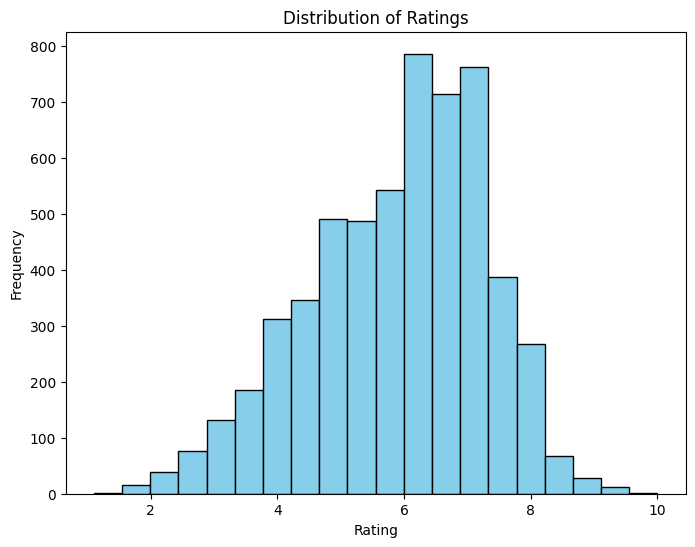

In [26]:
plt.figure(figsize=(8, 6))
plt.hist(df['Rating'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

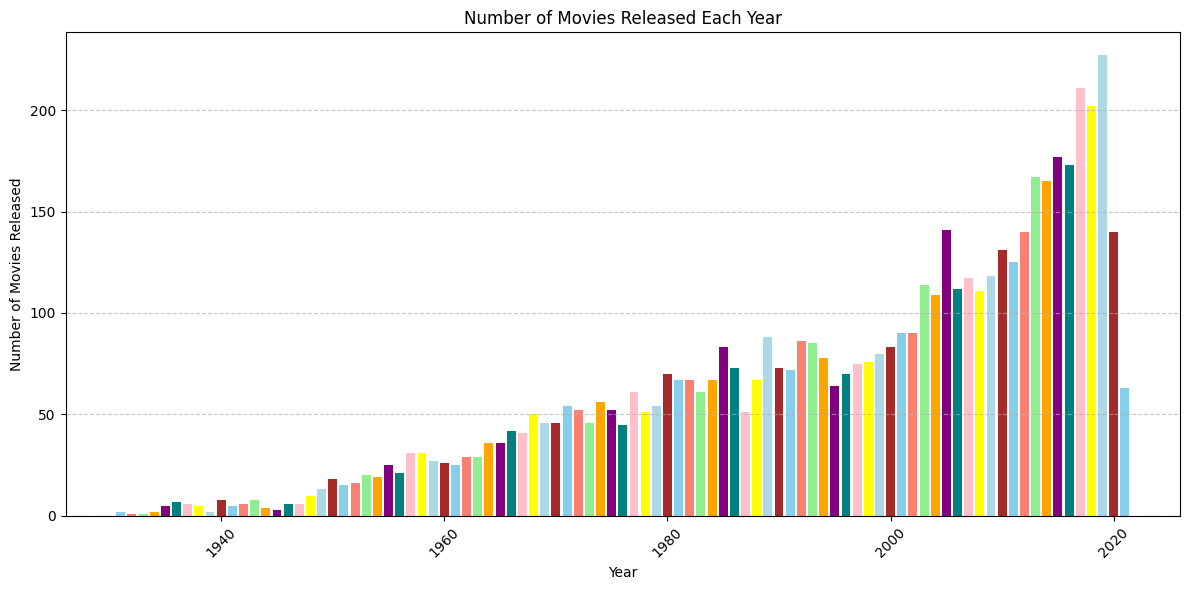

In [27]:
# Number of Movies per year

df["Year"] = df["Year"].astype(float)

movies_per_year = df["Year"].value_counts().sort_index()

colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'teal', 'pink', 'yellow', 'lightblue', 'brown']

plt.figure(figsize=(12, 6))
plt.bar(movies_per_year.index, movies_per_year.values, color=colors)
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Each Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Splitting the data into Train and Test

In [28]:
X = df[['Year', 'Duration', 'Votes', 'Avg_Rating_by_Actor']]
Y = df["Rating"]

In [29]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.25,random_state=42)

In [30]:
xtrain.shape

(4244, 4)

In [31]:
xtest.shape

(1415, 4)

In [32]:
ytrain.shape

(4244,)

In [33]:
ytest.shape

(1415,)

### Model Selection

In [34]:
# Initializing Models
models = {
    "Linear Regression" : LinearRegression(),
    "Random Forest" : RandomForestRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Ada Boost" : AdaBoostRegressor()
}

In [35]:
MSE = {}

# Training the models
for name, model in models.items():
    # model training
    model.fit(xtrain,ytrain)

    # making predictions
    predictions = model.predict(xtest)

    # Calculating the mean squared error
    mse = mean_squared_error(ytest, predictions)

    # Print the model performances
    print(f"{name}: ")
    print(f"Mean Squared Error: {mse}")
    print("-"*50)

    # Adding the mean squared errors in the dictionary MSE
    MSE[name] = mse

Linear Regression: 
Mean Squared Error: 1.6939803813411918
--------------------------------------------------


Random Forest: 
Mean Squared Error: 1.3775755100498626
--------------------------------------------------
Decision Tree: 
Mean Squared Error: 2.7465088339222614
--------------------------------------------------
Ada Boost: 
Mean Squared Error: 1.5348119712360548
--------------------------------------------------


In [36]:
print(MSE)

{'Linear Regression': 1.6939803813411918, 'Random Forest': 1.3775755100498626, 'Decision Tree': 2.7465088339222614, 'Ada Boost': 1.5348119712360548}


### Plotting the mean squared errors of all the models

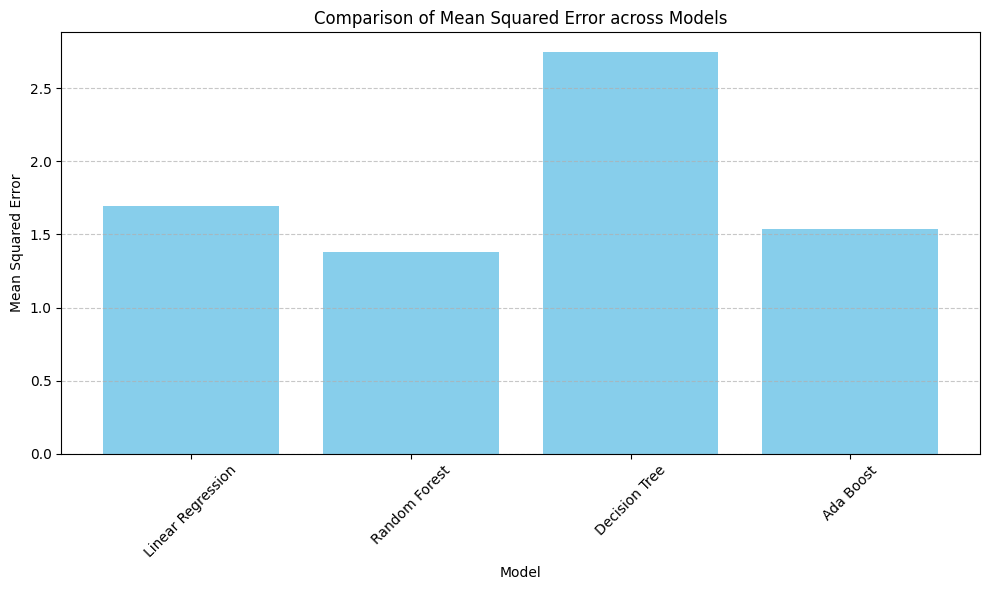

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(MSE.keys(), MSE.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Mean Squared Error across Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The Random Forest model has the lowest mean squared error of 1.37, indicating that it performs the best among the models evaluated in terms of predicting movie ratings based on the features provided. Therefore, the Gradient Boosting model can be considered the best model for this particular task.

### Hyperparameter Tuning for the Random Forest Model

In [39]:
rf_model = RandomForestRegressor(random_state=15)

hyp_grid = {"max_features": ["sqrt","log2"],
           "n_estimators": np.arange(1,100,10),
           "criterion": ["sqaured_error","absolute_error"],
           "max_depth": np.arange(1,15),
           "min_samples_split": np.arange(2,20),
            "min_samples_leaf" : np.arange(1,15),}

rscv = RandomizedSearchCV(rf_model, hyp_grid, cv=5)
rscv.fit(xtrain,ytrain)
rscv.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=7,
                      max_features='sqrt', min_samples_leaf=9,
                      min_samples_split=11, n_estimators=51, random_state=15)

### Model Training with the best Hyperparameters

In [40]:
rf_model = RandomForestRegressor(criterion='absolute_error', max_depth=7,
                      max_features='sqrt', min_samples_leaf=9,
                      min_samples_split=11, n_estimators=51, random_state=15)
rf_model.fit(xtrain, ytrain)

RandomForestRegressor(criterion='absolute_error', max_depth=7,
                      max_features='sqrt', min_samples_leaf=9,
                      min_samples_split=11, n_estimators=51, random_state=15)

### Model Evaluation

In [41]:
# Testing Data Evaluation

ypredtest = rf_model.predict(xtest)

MAE = mean_absolute_error(ytest, ypredtest)
print("mean_absolute_error: ", MAE)

MSE = mean_squared_error(ytest, ypredtest)
print("mean_squared_error: ", MSE)

R_Squared = r2_score(ytest, ypredtest)
print("R_Squared: ", R_Squared)

Adjusted_R2 = 1 - ((1 - R_Squared)*(len(xtest) - 1)) / (len(xtest) - len(X.columns) - 1)
print("Adjusted_R2: ", Adjusted_R2)

mean_absolute_error:  0.8632314834060831
mean_squared_error:  1.2938684849398776
R_Squared:  0.29158445560095303
Adjusted_R2:  0.28957476611329613


In [42]:
# Training Data Evaluation

ypredtrain = rf_model.predict(xtrain)

MAE = mean_absolute_error(ytrain, ypredtrain)
print("mean_absolute_error: ", MAE)

MSE = mean_squared_error(ytrain, ypredtrain)
print("mean_squared_error: ", MSE)

R_Squared = r2_score(ytrain, ypredtrain)
print("R_Squared: ", R_Squared)

Adjusted_R2 = 1 - ((1 - R_Squared)*(len(xtrain) - 1)) / (len(xtrain) - len(X.columns) - 1)
print("Adjusted_R2: ", Adjusted_R2)

mean_absolute_error:  0.8416874572637726
mean_squared_error:  1.2802237860918424
R_Squared:  0.3380779065007574
Adjusted_R2:  0.33745330438374943
